# **CV2 - Final Project**

**Stav Suzan Rabinovich   208661090**\
**Lior Mitrany  205478258**

## Intro
To be continued...

## Imports

In [1]:
import  numpy as np
import  pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import  random
import  glob
import  matplotlib.pyplot as plt
import  os
# import torchmetrics
# import timm
# from    scipy.signal import  convolve2d
from    PIL import Image
import  sys
# from    google.colab.patches  import cv2_imshow

import  cv2
from    cv2 import imread

from    sklearn import svm, datasets
from    sklearn.model_selection import train_test_split
from    sklearn.metrics import confusion_matrix, plot_confusion_matrix

from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

## Setup

In [2]:
!nvidia-smi

Fri Apr 22 09:44:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P0    22W /  N/A |      0MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Check if Cuda is aviable

In [3]:
torch.cuda.is_available()

True

#### Cuda Vesrsion

In [4]:
torch.version.cuda # check the cuda version

'11.3'

#### Checking what is the Cuda device

In [5]:
print(f'Device = {torch.cuda.current_device()}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Select the gpu device
torch.cuda.get_device_name(0) # Get the device name

Device = 0


'NVIDIA GeForce RTX 3070 Laptop GPU'

In [6]:
%load_ext autoreload
%autoreload 2

# Data

In [7]:
current_path = !pwd
print(f'Current path = {current_path}')
# path_imgs = current_path[0] + '/Pictures/CUB_200_2011/images'
path_imgs = current_path[0] + '/Birds_Images'
print(f'Path to all images = {path_imgs}')

Current path = ['/mnt/d/ComputerVisionGan']
Path to all images = /mnt/d/ComputerVisionGan/Birds_Images


### The birds we are working with are:

In [8]:
# birds_DB = ['House_Sparrow', 'American_Pipit', 'Gadwall', 'European_Goldfinch','Horned_Grebe']
# chosen_bird = ['048.European_Goldfinch']
# print(chosen_bird[0])

# full_path = path_imgs + '/' # + chosen_bird[0]
# print(f'Full path = {full_path}')

In [9]:
# Old batch size 32
batch_size = 32


# # 64X64 images
# transform = transforms.Compose([transforms.Resize(64),
#                                 transforms.CenterCrop(64),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 256*256 images!
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [10]:
train_data = datasets.ImageFolder(path_imgs, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)

print(f'The amount of birds classes is: {len(train_loader.dataset.classes)}')
print(f'The name of the class is {train_loader.dataset.classes}')


The amount of birds classes is: 1
The name of the class is ['Birds']


In [11]:
imgs, label = next(iter(train_loader))

imgs = imgs.numpy().transpose(0, 2, 3, 1)

### Generator class

Generator intro...

In [12]:
# class Generator(nn.Module):
#     def __init__(self, nz, nfeats, nchannels):
#         super(Generator, self).__init__()

#         # input is Z, going into a convolution
#         self.conv1 = nn.ConvTranspose2d(nz, nfeats * 8, 4, 1, 0, bias=False)
#         self.bn1 = nn.BatchNorm2d(nfeats * 8)
#         # state size. (nfeats*8) x 4 x 4
        
#         self.conv2 = nn.ConvTranspose2d(nfeats * 8, nfeats * 8, 4, 2, 1, bias=False)
#         self.bn2 = nn.BatchNorm2d(nfeats * 8)
#         # state size. (nfeats*8) x 8 x 8
        
#         self.conv3 = nn.ConvTranspose2d(nfeats * 8, nfeats * 4, 4, 2, 1, bias=False)
#         self.bn3 = nn.BatchNorm2d(nfeats * 4)
#         # state size. (nfeats*4) x 16 x 16
        
#         self.conv4 = nn.ConvTranspose2d(nfeats * 4, nfeats * 2, 4, 2, 1, bias=False)
#         self.bn4 = nn.BatchNorm2d(nfeats * 2)
#         # state size. (nfeats * 2) x 32 x 32
        
#         self.conv5 = nn.ConvTranspose2d(nfeats * 2, nfeats, 4, 2, 1, bias=False)
#         self.bn5 = nn.BatchNorm2d(nfeats)
#         # state size. (nfeats) x 64 x 64
        
#         self.conv6 = nn.ConvTranspose2d(nfeats, nchannels, 3, 1, 1, bias=False)
#         # state size. (nchannels) x 64 x 64

#     def forward(self, x):
#         x = F.leaky_relu(self.bn1(self.conv1(x)))
#         x = F.leaky_relu(self.bn2(self.conv2(x)))
#         x = F.leaky_relu(self.bn3(self.conv3(x)))
#         x = F.leaky_relu(self.bn4(self.conv4(x)))
#         x = F.leaky_relu(self.bn5(self.conv5(x)))
#         x = torch.tanh(self.conv6(x))
        
#         return x
class Generator(nn.Module):
    def __init__(self, nz, nfeats, nchannels):
        super(Generator, self).__init__()

        # input is Z, going into a convolution
        self.conv1 = nn.ConvTranspose2d(nz, nfeats * 32, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(nfeats * 32)
        # state size. (nfeats*8) x 4 x 4
        
        self.conv2 = nn.ConvTranspose2d(nfeats * 32, nfeats * 16, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(nfeats * 16)
        # state size. (nfeats*8) x 8 x 8
        
        self.conv3 = nn.ConvTranspose2d(nfeats * 16, nfeats * 8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*4) x 16 x 16
        
        self.conv4 = nn.ConvTranspose2d(nfeats * 8, nfeats * 4, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats * 4) x 32 x 32
        
        self.conv5 = nn.ConvTranspose2d(nfeats * 4, nfeats * 2, 4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats) x 64 x 64
        
        self.conv6 = nn.ConvTranspose2d(nfeats * 2, nfeats, 4, 2, 1, bias=False)
        self.bn6 = nn.BatchNorm2d(nfeats)
        # state size. (nfeats) x 128 x 128
        
        self.conv7 = nn.ConvTranspose2d(nfeats, nfeats, 4, 2, 1, bias=False)
        self.bn7 = nn.BatchNorm2d(nfeats)
        # state size. (nfeats) x 256 x 256
        
        self.conv8 = nn.ConvTranspose2d(nfeats, nchannels, 3, 1, 1, bias=False)
        # state size. (nchannels) x 256 x 256

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = F.leaky_relu(self.bn5(self.conv5(x)))
        x = F.leaky_relu(self.bn6(self.conv6(x)))
        x = F.leaky_relu(self.bn7(self.conv7(x)))
        x = torch.tanh(self.conv8(x))
        
        return x


### Discriminator

Discriminator intro...

In [13]:
# class Discriminator(nn.Module):
#     def __init__(self, nchannels, nfeats):
#         super(Discriminator, self).__init__()
#         # super(self, Discriminator).__init__()

#         # input is (nchannels) x 64 x 64
#         self.conv1 = nn.Conv2d(nchannels, nfeats, 4, 2, 1, bias=False)
#         # state size. (nfeats) x 32 x 32
        
#         self.conv2 = nn.Conv2d(nfeats, nfeats * 2, 4, 2, 1, bias=False)
#         self.bn2 = nn.BatchNorm2d(nfeats * 2)
#         # state size. (nfeats*2) x 16 x 16
        
#         self.conv3 = nn.Conv2d(nfeats * 2, nfeats * 4, 4, 2, 1, bias=False)
#         self.bn3 = nn.BatchNorm2d(nfeats * 4)
#         # state size. (nfeats*4) x 8 x 8
       
#         self.conv4 = nn.Conv2d(nfeats * 4, nfeats * 8, 4, 2, 1, bias=False)
#         self.bn4 = nn.BatchNorm2d(nfeats * 8)
#         # state size. (nfeats*8) x 4 x 4
        
#         self.conv5 = nn.Conv2d(nfeats * 8, 1, 4, 1, 0, bias=False)
#         # state size. 1 x 1 x 1
        
#     def forward(self, x):
#         x = F.leaky_relu(self.conv1(x), 0.2)
#         x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
#         x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
#         x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
#         x = torch.sigmoid(self.conv5(x))
        
#         return x.view(-1, 1)

class Discriminator(nn.Module):
    def __init__(self, nchannels, nfeats):
        super(Discriminator, self).__init__()

        # input is (nchannels) x 256 x 256
        self.conv1 = nn.Conv2d(nchannels, nfeats, 4, 2, 1, bias=False)
        # state size. (nfeats) x 128 x 128
        
        self.conv2 = nn.Conv2d(nfeats, nfeats * 2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats*2) x 64 x 64
        
        self.conv3 = nn.Conv2d(nfeats * 2, nfeats * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*2) x 32 x 32
        
        self.conv4 = nn.Conv2d(nfeats * 4, nfeats * 8, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*2) x 16 x 16
        
        self.conv5 = nn.Conv2d(nfeats * 8, nfeats * 16, 4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(nfeats * 16)
        # state size. (nfeats*4) x 8 x 8
       
        self.conv6 = nn.Conv2d(nfeats * 16, nfeats * 32, 4, 2, 1, bias=False)
        self.bn6 = nn.BatchNorm2d(nfeats * 32)
        # state size. (nfeats*8) x 4 x 4
        
        self.conv7 = nn.Conv2d(nfeats * 32, 1, 4, 1, 0, bias=False)
        # state size. 1 x 1 x 1
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = F.leaky_relu(self.bn5(self.conv5(x)), 0.2)
        x = F.leaky_relu(self.bn6(self.conv6(x)), 0.2)
        x = torch.sigmoid(self.conv7(x))
        
        return x.view(-1, 1)

In [14]:
# od value 0.0003
lr = 0.001
beta1 = 0.01

weights_path = current_path[0] + '/Weights'

print(f'Device = {device}')

netG = Generator(100, 32, 3).to(device)
netD = Discriminator(3, 48).to(device)

# Path to the weights
discriminator_path =  weights_path + '/Discriminator_weights.pth'
generator_path = weights_path + '/Generator_weights.pth'


# If there are already saved weights, load them to the modles
if len(os.listdir(weights_path)) != 0:
    print('Found wighest for the models!\nLoading weights...')
    netD.load_state_dict(torch.load(discriminator_path))
    netG.load_state_dict(torch.load(generator_path))
    print('Weights are loaded to the models.')
else:
    print('No weights to load...')

# Binary Cross Entropy
criterion = nn.BCELoss()
# This is used for measuring the error of a reconstruction in for example an auto-encoder.

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

nz = 100
fixed_noise = torch.randn(25, nz, 1, 1, device=device)

# old value 0.9
real_label = 0.99

fake_label = 0

batch_size = train_loader.batch_size

if next(netG.parameters()).is_cuda and next(netD.parameters()).is_cuda:
    print('Both models are running on cuda!')

Device = cuda
Found wighest for the models!
Loading weights...
Weights are loaded to the models.
Both models are running on cuda!


### Training

In [15]:
# Old value 3
epochs = 10

step = 0
for i, epoch in enumerate(range(epochs)):
    for ii, (real_images, train_labels) in enumerate(train_loader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real

        # set the gradients to zero before starting to do backpropragation
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        
        labels = torch.full((batch_size, 1), real_label, device=device)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        step += 1
        # Save the weights from this round
        torch.save(netD.state_dict(), discriminator_path)
        torch.save(netG.state_dict(), generator_path)
        
    # print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
    #         % (epoch + 1, epochs, ii, len(train_loader),
    #             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    print(f'Epoch: [{i +1}/{epochs}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} D(x) {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
    valid_image = netG(fixed_noise)



Epoch: [1/10] Loss_D: 1.3617 Loss_G: 1.0098 D(x) 0.5575 D(G(z)): 0.5261 / 0.3758
Epoch: [2/10] Loss_D: 1.4889 Loss_G: 0.8467 D(x) 0.5178 D(G(z)): 0.5588 / 0.4341
Epoch: [3/10] Loss_D: 1.3874 Loss_G: 0.6955 D(x) 0.5246 D(G(z)): 0.5187 / 0.5003
Epoch: [4/10] Loss_D: 1.3773 Loss_G: 0.7780 D(x) 0.4846 D(G(z)): 0.4724 / 0.4625
Epoch: [5/10] Loss_D: 1.3734 Loss_G: 0.8393 D(x) 0.4961 D(G(z)): 0.4827 / 0.4324
Epoch: [6/10] Loss_D: 1.4485 Loss_G: 0.8155 D(x) 0.4723 D(G(z)): 0.4979 / 0.4448
Epoch: [7/10] Loss_D: 1.3795 Loss_G: 0.8057 D(x) 0.5339 D(G(z)): 0.5158 / 0.4538
Epoch: [8/10] Loss_D: 1.3149 Loss_G: 0.7795 D(x) 0.5164 D(G(z)): 0.4743 / 0.4672
Epoch: [9/10] Loss_D: 1.4142 Loss_G: 0.7900 D(x) 0.4957 D(G(z)): 0.5055 / 0.4548
Epoch: [10/10] Loss_D: 1.5460 Loss_G: 0.8545 D(x) 0.4292 D(G(z)): 0.4953 / 0.4283


### Save 10  Generative adversarial network images and save them

In [16]:
# im_batch_size = 10
n_images=10

saved_image_path = current_path[0] + '/output_images'

if not os.path.exists(saved_image_path):
    os.mkdir(saved_image_path)


# for i_batch in range(0, n_images, im_batch_size):
#     gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
#     gen_images = netG(gen_z)
#     images = gen_images.to("cpu").clone().detach()
#     images = images.numpy().transpose(0, 2, 3, 1)
#     for i_image in range(gen_images.size(0)):
#         save_image(gen_images[i_image, :, :, :], os.path.join(saved_image_path, f'image_{i_batch+i_image:05d}.jpg'))

for i in range(n_images):
    gen_z = torch.randn(1, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join(saved_image_path, f'image_{i+i_image:03d}.jpg'))

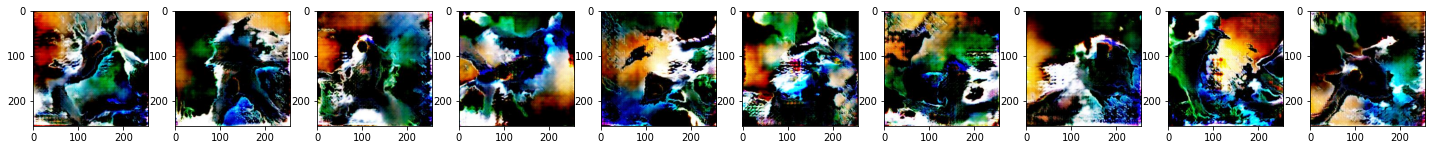

In [17]:
def load_images_from_folder(folder_path):
    imgs = []
    for file_name in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, file_name))
        if img is not None:
            imgs.append(img)
    return imgs        

def show_imgs(imgs, columns=10, rows=10):
    display_size = (25, 25)
    fig = plt.figure(figsize=display_size)
    for i, img in enumerate(imgs):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img)
    plt.show()

imgs = load_images_from_folder(saved_image_path)

show_imgs(imgs)

### Beacuse the images are really dark, We will try to improve thier brightness to see if the images are really like birds.

# Improving the images brightness

## Hue, Saturation, Value:

HSV Color Scale: The HSV (which stands for Hue Saturation Value) scale provides a numerical readout of your image that corresponds to the color names contained therein. Hue is measured in degrees from 0 to 360. For instance, cyan falls between 181–240 degrees, and magenta falls between 301–360 degrees. The value and saturation of a color are both analyzed on a scale of 0 to 100 percent. Most digital color pickers are based on the HSV scale, and HSV color models are particularly useful for selecting precise colors for art, color swatches, and digital graphics.

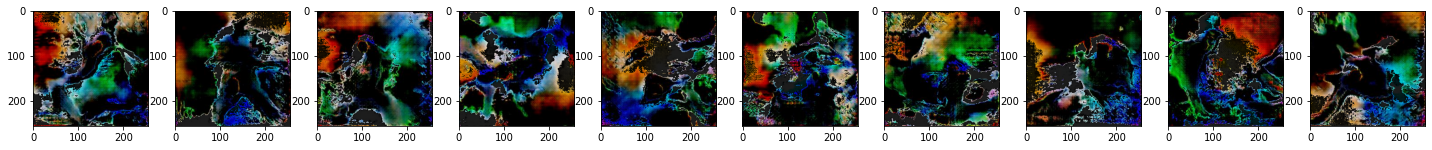

In [18]:
def increase_brightness(imgs, value=30):
    for i in range(len(imgs)):
        hsv = cv2.cvtColor(imgs[i], cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        lim = 255 - value
        # Every number in the array that above lim will set to 25
        lim = 255 - value
        v[v > lim] += value
        final_hsv = cv2.merge((h, s, v))
        imgs[i] = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

increase_brightness(imgs)

show_imgs(imgs)

In [19]:
imgs = load_images_from_folder(saved_image_path)
# Adding brightness to the images
for img in imgs:
    pass
    # img = img.sja

## TODO
* Learn about kernel matrix of cv2 and check for improvment. https://pyimagesearch.com/2016/07/25/convolutions-with-opencv-and-python/
* Add an explanation about the kernel matrix and why we used that.
* run more epochs.
* check how to improve the algorithm.
* Add more information about things we used.